# Introduction

The purpose of this notebook is to build CNN's for digit classification using the famous MNIST dataset. This is one of those classical examples in computer vision that is important in its own right but also incredibly interesting to learn from. Applications of such algorithms include reading bank cheques for example. It is therefore clear why we need to achieve incredibly high accuracy in our algorithms.  

# Libraries

In [1]:
# Core
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(style='darkgrid', font_scale=1.4)
import matplotlib.pyplot as plt
%matplotlib inline
import time
import warnings
warnings.filterwarnings("ignore")

# Sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score

# Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.utils import plot_model


**Reproducibility**

In [2]:
# Random seeds
def set_seed(seed=0):
    np.random.seed(seed)
    tf.random.set_seed(seed)
set_seed()

# Data

In [3]:
# Training data
train_data = pd.read_csv(r"C:\Users\Udit Goel\Desktop\FDM Project\MNIST Data\train.csv")
test_data  = pd.read_csv(r"C:\Users\Udit Goel\Desktop\FDM Project\MNIST Data\test.csv")
# sub = pd.read_csv(r"C:\Users\Udit Goel\Desktop\FDM Project\MNIST Data\sample_submission.csv")
print("Data are Ready!!")
# Dimensions
print('Training dataframe dimensions:',train_data.shape)
print('Test dataframe dimensions:',test_data.shape)

# First 5 entries of training data
train_data.head()

Data are Ready!!
Training dataframe dimensions: (42000, 785)
Test dataframe dimensions: (28000, 784)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**Check for null values**

In [4]:
# Missing values values
print('Number of null values in training set:',train_data.isnull().sum().sum())
print('')
print('Number of null values in test set:',test_data.isnull().sum().sum())

Number of null values in training set: 0

Number of null values in test set: 0


**Preview first few images**

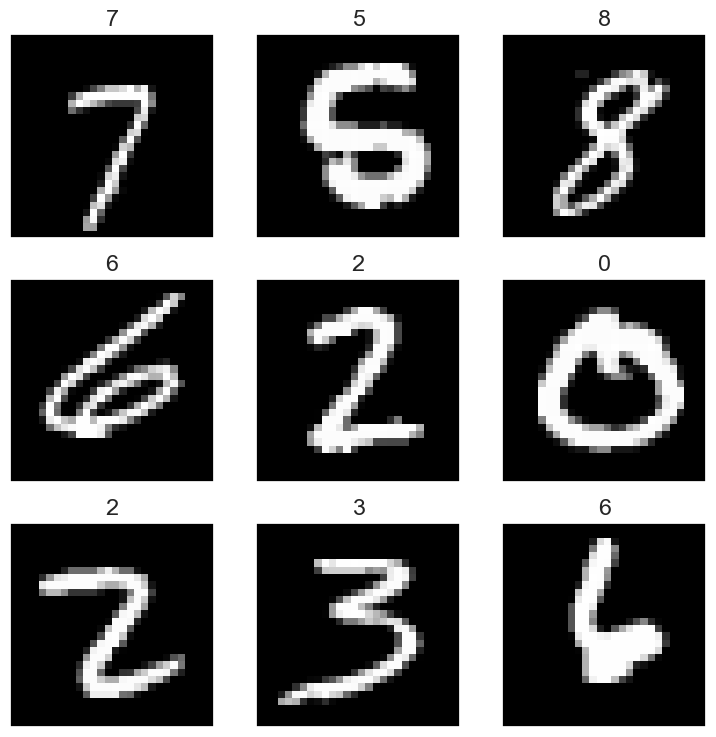

In [5]:
# Figure size
plt.figure(figsize=(9,9))

# Subplot 
for i in range(9):
    img = np.asarray(train_data.iloc[i+18,1:].values.reshape((28,28))/255);
    ax=plt.subplot(3, 3, i+1)
    ax.grid(False)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.title.set_text(f'{train_data.iloc[i+18,0]}')
    plt.imshow(img, cmap='gray')
    
plt.show()

**Explore label distribution**

Text(0.5, 1.0, 'Distribution of labels in training set')

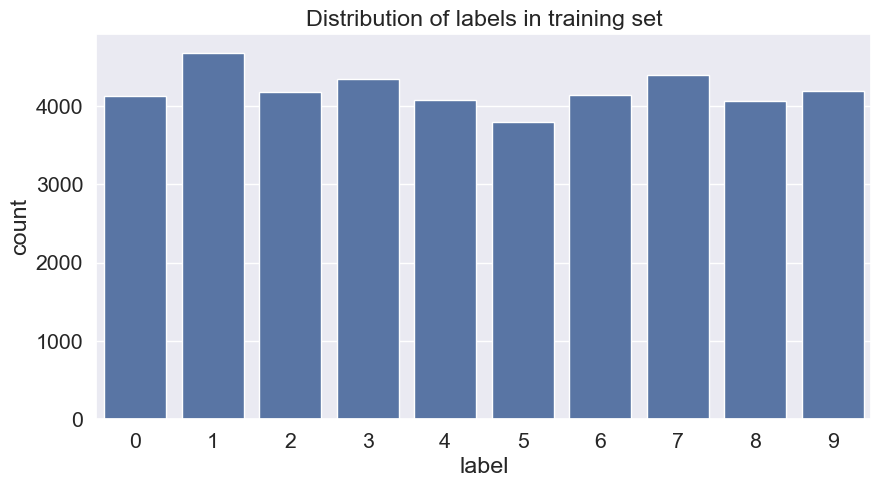

In [6]:
# Figure size
plt.figure(figsize=(10,5))

# Countplot
sns.countplot(x='label', data=train_data)
plt.title('Distribution of labels in training set')

**Labels and features**

In [7]:
# Labels
y=train_data.label

# Scale features to be in [0,1]
X=train_data.drop('label', axis=1)/255

# Delete to save memory
del train_data

In [8]:
#Adding some randomized misclassified labels to the training data 

import numpy as np
corruption_level = 0.1 


# def partially_corrupt_labels(y_train, corruption_level=0.1):
n_samples = len(y)
n_corrupt = int(corruption_level * n_samples)
corrupt_indices = np.random.choice(n_samples, n_corrupt)
new_labels = np.random.choice(10, n_corrupt)
y_train_corrupted = y.copy()
y_train_corrupted[corrupt_indices] = new_labels
# return y_train_corrupted
print(corrupt_indices)

[ 2732 21243 30403 ... 13646 27014  4641]


In [9]:
#Checking if the labels are actually corrupted

y_train_corrupted.shape
temp = []
for i in range(len(y)):
    if y_train_corrupted[i] != y[i]:
        print(y[i])
        temp.append(y[i])


print(len(temp))

8
5
4
2
0
2
4
1
4
6
9
8
5
0
0
7
5
8
4
4
8
9
9
4
3
2
7
6
0
0
5
7
8
7
7
3
2
5
2
9
0
7
5
5
0
2
6
6
3
9
6
7
2
2
4
4
0
7
8
1
1
4
8
9
7
4
1
3
0
5
0
8
6
0
2
2
6
0
9
8
5
2
8
8
7
7
8
3
9
7
6
6
9
1
0
4
7
8
1
7
8
9
4
4
7
9
4
8
2
3
4
4
9
7
5
2
1
9
1
1
6
1
5
2
3
4
2
8
8
3
6
7
2
7
6
7
1
1
1
1
0
2
9
6
6
2
2
4
4
4
1
9
9
0
0
0
5
4
6
1
8
2
6
4
3
8
9
4
9
3
0
7
7
6
7
1
1
7
5
1
0
1
1
5
6
8
2
4
7
0
1
4
4
4
6
0
7
3
1
2
6
2
3
6
1
9
4
6
7
3
2
3
5
4
8
5
5
3
7
6
0
5
7
0
5
1
3
6
8
6
9
8
0
0
4
8
1
3
6
9
4
8
7
1
2
2
9
7
1
4
8
6
8
1
2
8
4
2
9
0
8
5
1
3
3
8
6
3
7
8
5
8
7
3
7
6
3
5
7
1
9
2
6
2
1
5
7
0
0
5
7
1
0
5
1
5
6
6
2
9
5
7
5
1
6
3
6
3
1
5
0
4
7
3
6
0
6
5
4
3
0
0
8
6
5
8
5
5
3
8
2
8
6
9
0
9
0
7
5
9
2
9
9
7
1
0
8
4
4
1
6
0
2
4
1
7
2
0
5
8
2
7
6
0
8
6
1
8
3
6
2
4
4
8
3
6
3
3
7
2
6
9
8
2
6
2
6
7
9
8
1
1
6
9
1
2
4
6
5
5
0
2
2
7
6
1
2
7
3
2
1
9
8
9
5
0
2
0
0
7
3
3
8
3
1
7
1
3
9
4
2
8
4
4
5
5
7
1
1
1
8
4
3
0
2
8
7
8
1
7
6
6
4
0
9
1
7
4
8
6
7
1
8
9
0
4
5
1
2
9
3
5
9
9
2
3
1
4
6
7
4
4
9
2
3
8
9
9
4
5
6
1
4
2
4
3
3
7
1
7


**Reshape data**

In [10]:
# Reshape (-1 means unspecified)
X = X.values.reshape(-1, 28, 28, 1)

# Save test data index for submission
test_index = test_data.index

# Reshape
test_data = test_data.values.reshape(-1, 28, 28, 1)

# Data Augmentation

Data Augmentation is a clever trick that uses your existing training set to create additional 'fake' data by applying small transformations at every epoch. This doesn't change the size of your training set, it just modifies each image slightly at every epoch so the network becomes for robust over many epochs.

**Visualise augmentations**

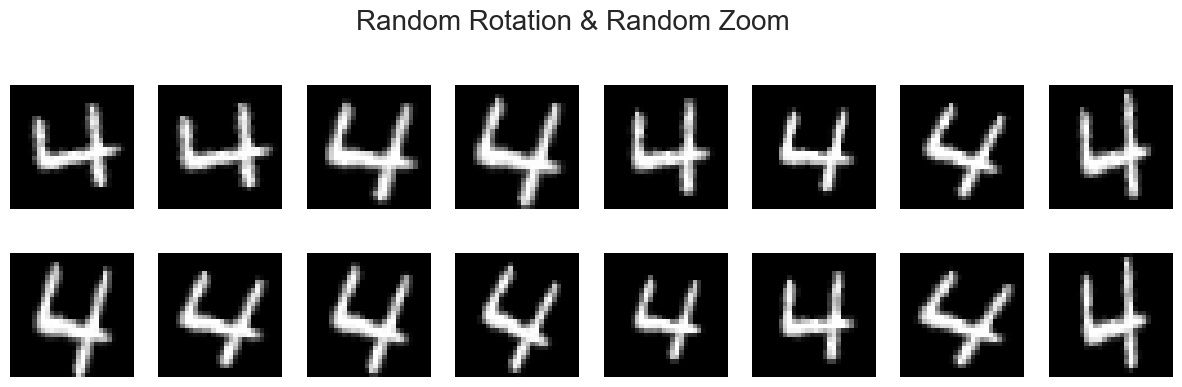

In [11]:
# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range = 18,           # 18 degrees
    zoom_range=0.2,                # 20 %
    fill_mode='constant',          # edge pixels
    cval=0                         # fill value
)

aug = datagen.flow(X[42].reshape(-1, 28, 28, 1))

# Plot using a for loop
fig, axes = plt.subplots(2, 8, figsize = (15, 4))
plt.suptitle('Random Rotation & Random Zoom', fontsize=20, y=1.05)
axes = axes.ravel()

for i in range(16):
    
    aug_img = next(aug)[0]
    axes[i].imshow(aug_img, cmap = 'gray')
    axes[i].axis('off')
    
plt.show()

We'll actually use keras' preprocessing library instead of ImageDataGenerator. This is because the latter works on a CPU whereas the former works on a GPU so this will be faster.

# Model

In [12]:
# Define model
def build_model():
    model = keras.Sequential([

        # Data Augmentation
        preprocessing.RandomRotation(factor=0.05, fill_mode='constant'),     # 18 degrees
        preprocessing.RandomZoom(height_factor=(-0.2,0.2), width_factor=(-0.2,0.2), fill_mode='constant'),  # 20%

        # Convolutional layer 1
        layers.Conv2D(filters=64, kernel_size=5, strides=1, padding='same', input_shape=[28,28,1], activation='relu'),
        layers.MaxPool2D(pool_size=2, padding='same'),
        layers.Dropout(rate=0.3),

        # Convolutional layer 2
        layers.Conv2D(filters=128, kernel_size=3, strides=1, padding='same', activation='relu'),
        layers.MaxPool2D(pool_size=4, padding='same'),
        layers.Dropout(rate=0.3),
        layers.Flatten(),

        # Hidden layer 3
        layers.Dense(units=256, activation='relu'),
        layers.Dropout(rate=0.4),

        # Output layer (softmax returns a probability distribution)
        layers.Dense(units=10, activation='softmax')
    ])

    # Define optimizer, loss function and accuracy metric
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['sparse_categorical_accuracy'])
    
    return model

**Early stopping**

In [13]:
# Define early stopping callback on validation loss
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
)

# Reduce learning rate when validation loss plateaus
reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5
)

# Cross validation

In [14]:
FOLDS = 10
EPOCHS = 200
BATCH_SIZE = 500

test_preds = np.zeros((1, 1))
scores = []
times = []
history_df = pd.DataFrame()

cv = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=0)

for fold, (train_idx, val_idx) in enumerate(cv.split(X, y)):
    # Start timer
    start = time.time()
    
    # get training and validation sets
    X_train, X_valid = X[train_idx], X[val_idx]
    y_train, y_valid = y_train_corrupted[train_idx], y[val_idx]

    # Build and train model
    model = build_model()
    fold_history = model.fit(
        X_train,
        y_train,
        validation_data=(X_valid, y_valid),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        #callbacks=[early_stopping, reduce_lr],
        verbose=True
    )
    
    # history_df = history_df.append(pd.DataFrame(fold_history.history))
    # temp_hist = [x for x in fold_history.history]
    print(type(fold_history.history))
    temp = pd.DataFrame.from_dict(fold_history.history)
    print(temp)

    history_df = pd.concat([temp, history_df])
    

    
    # Make predictions and measure accuracy
    y_pred = np.argmax(model.predict(X_valid), axis=1)
    score = accuracy_score(y_valid, y_pred)
    scores.append(score)
    
    # Store predictions
    test_preds = test_preds + model.predict(test_data)
    
    # Stop timer
    stop = time.time()
    times.append((stop - start)/60)
    
    # Print accuracy and time
    print(f'Fold {fold} - Accuracy: {score}, Time: {round((stop - start)/60,1)} mins')
    
print('')
print(f'Mean Accuracy: {np.mean(scores)}')





Epoch 1/200


76/76 [==============================] - 12s 142ms/step - loss: 1.2185 - sparse_categorical_accuracy: 0.6501 - val_loss: 0.2087 - val_sparse_categorical_accuracy: 0.9579
Epoch 2/200
76/76 [==============================] - 10s 136ms/step - loss: 0.7508 - sparse_categorical_accuracy: 0.8501 - val_loss: 0.1544 - val_sparse_categorical_accuracy: 0.9707
Epoch 3/200
76/76 [==============================] - 10s 133ms/step - loss: 0.6921 - sparse_categorical_accuracy: 0.8695 - val_loss: 0.1256 - val_sparse_categorical_accuracy: 0.9755
Epoch 4/200
76/76 [==============================] - 10s 132ms/step - loss: 0.6629 - sparse_categorical_accuracy: 0.8768 - val_loss: 0.1072 - val_sparse_categorical_accuracy: 0.9793
Epoch 5/200
76/76 [==============================] - 10s 134ms/step - loss: 0.6424 - sparse_categorical_accuracy: 0.8827 - val_loss: 0.1091 - val_sparse_categorical_accuracy: 0.9843
Epoch 6/200
76/76 [==============================] - 10s 134ms/step - loss: 0.6351 - 

In [15]:
history_df.reset_index
history_df
history_df.to_csv('history_df.csv', index=False)

In [16]:
scores

[0.9945238095238095,
 0.995,
 0.9930952380952381,
 0.9928571428571429,
 0.9916666666666667,
 0.9928571428571429,
 0.9928571428571429,
 0.9942857142857143,
 0.9911904761904762,
 0.995]

**Plot fold accuracy**

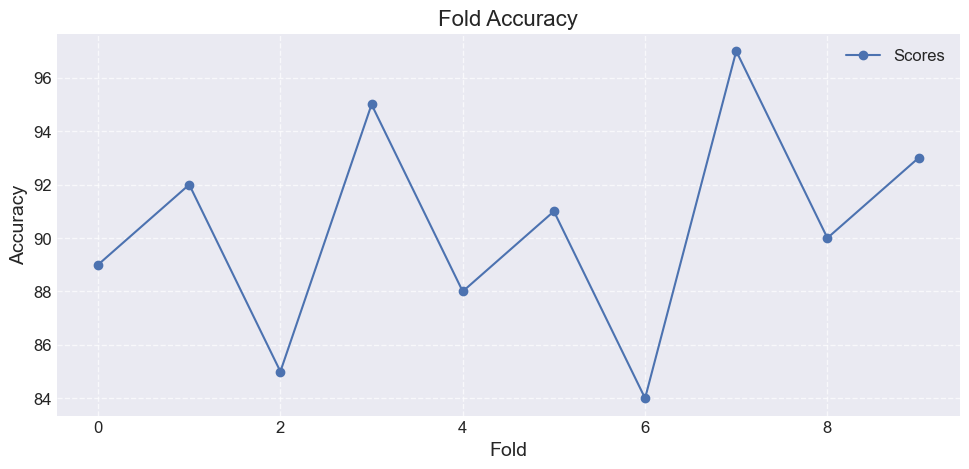

In [17]:

plt.style.use("seaborn-v0_8-dark")

# x  = [x for x in range(10)]
# print(x)
# print(scores)
# # Figure size
# plt.figure(figsize=(10,5))

# # Line plot
# plt.plot(x, scores)
# # plt.plot(np.mean(scores)*np.ones(len(scores)), c='black', label='mean')

# # Aesthetics
# plt.title('Fold accuracy')
# plt.xlabel('Fold')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.show()

import matplotlib.pyplot as plt
import numpy as np

# Define scores
scores = [89, 92, 85, 95, 88, 91, 84, 97, 90, 93]

# x values
x = [x for x in range(10)]

# Figure size
plt.figure(figsize=(10,5))

# Line plot
plt.plot(x, scores, marker='o', linestyle='-', color='b', label='Scores')

# Grid lines
plt.grid(True, linestyle='--', alpha=0.7)

# Aesthetics
plt.title('Fold Accuracy', fontsize=16)
plt.xlabel('Fold', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()
%matplotlib inline

**Plot fold time**

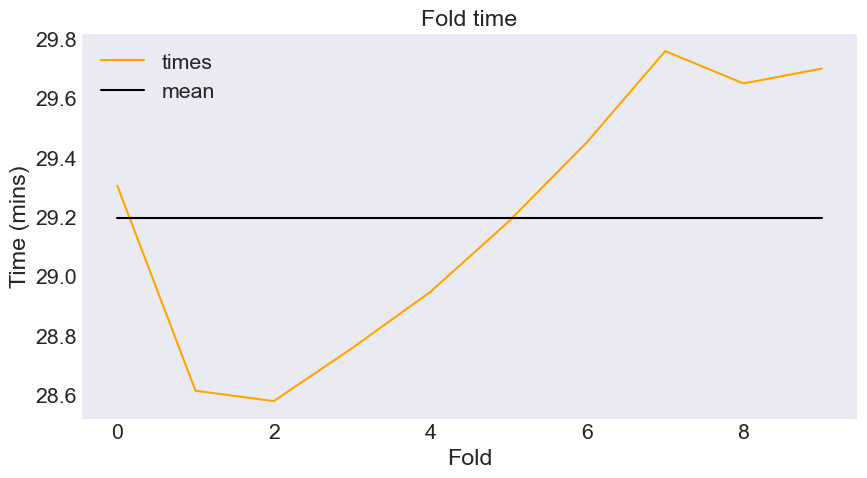

In [18]:
# Figure size

plt.style.use("seaborn-v0_8-dark")
plt.figure(figsize=(10,5))

# Line plot
plt.plot(times, label='times', c='orange')
plt.plot(np.mean(times)*np.ones(len(times)), c='black', label='mean')

# Aesthetics
plt.title('Fold time')
plt.xlabel('Fold')
plt.ylabel('Time (mins)')
plt.legend()

**Plot learning curves**

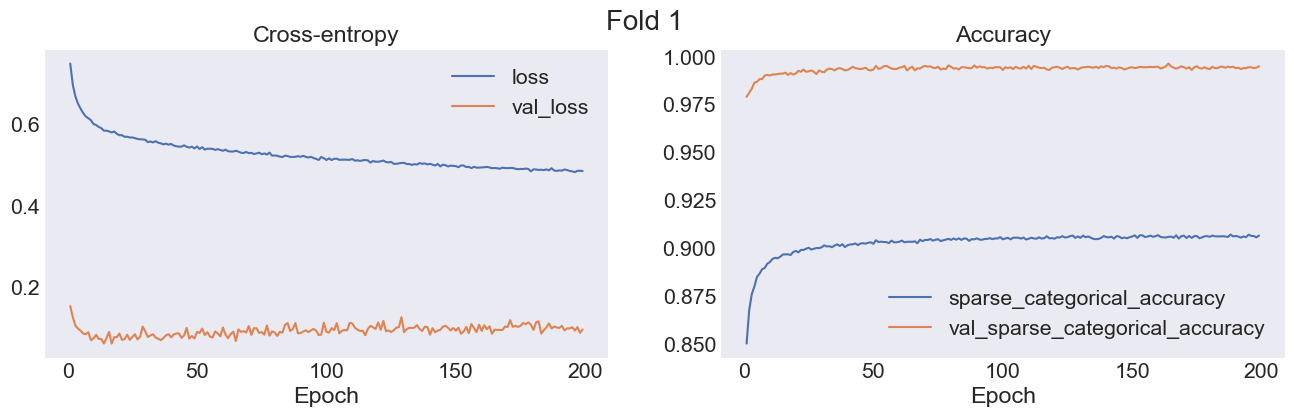

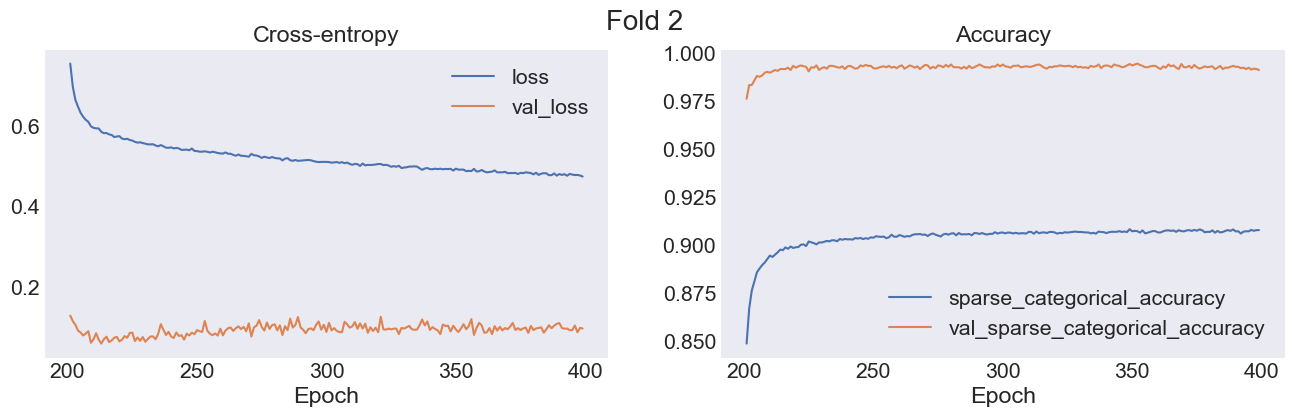

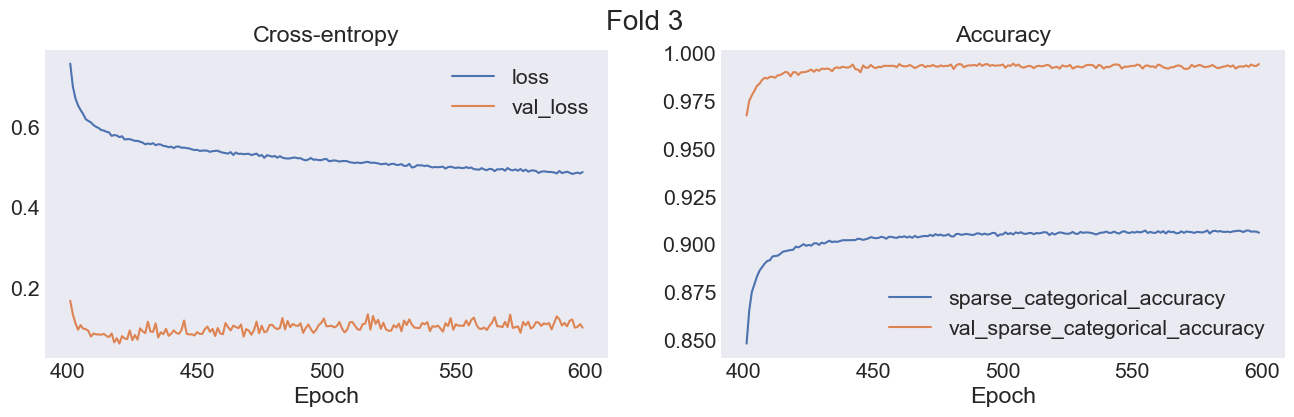

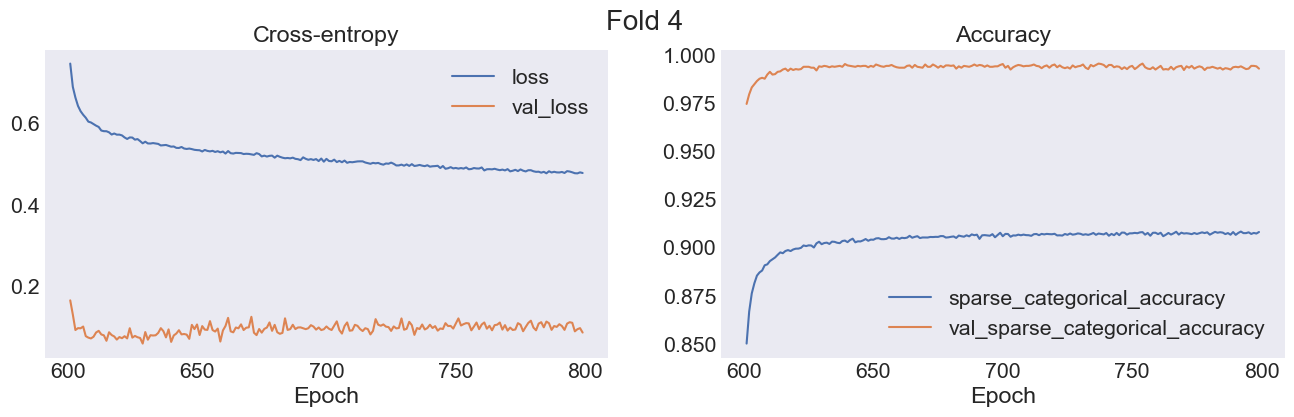

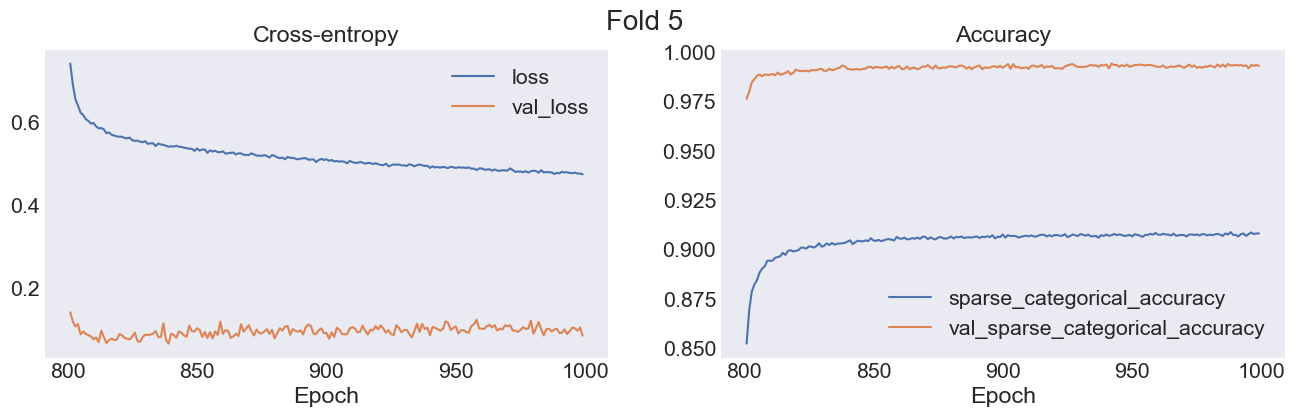

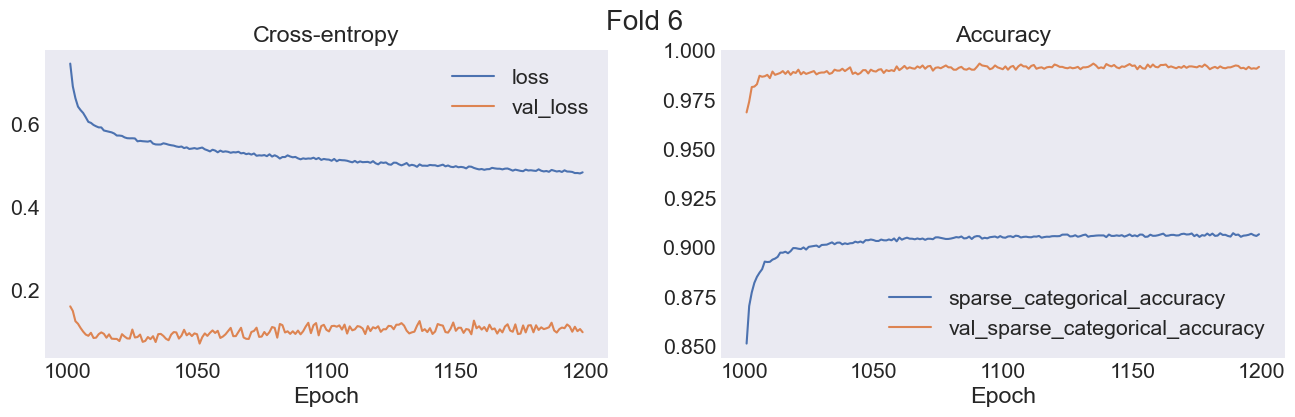

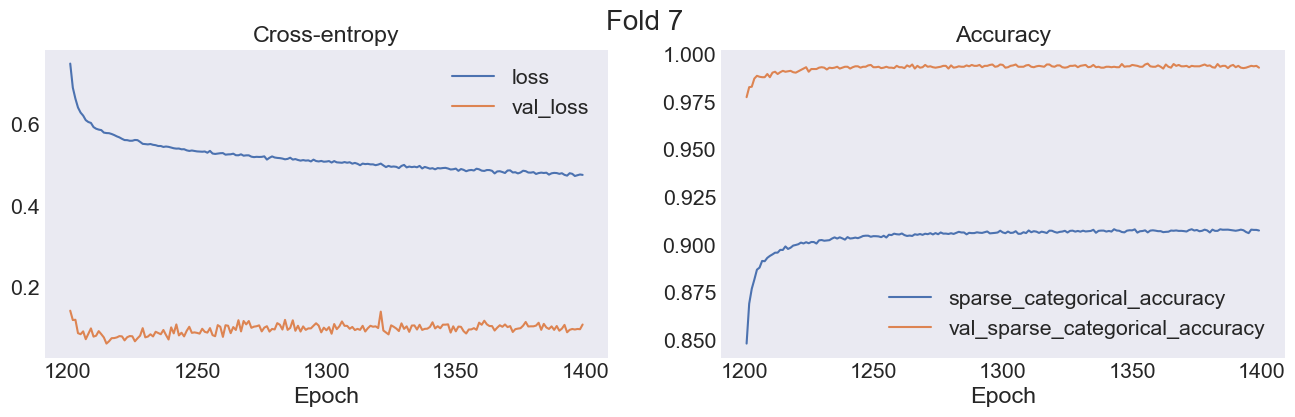

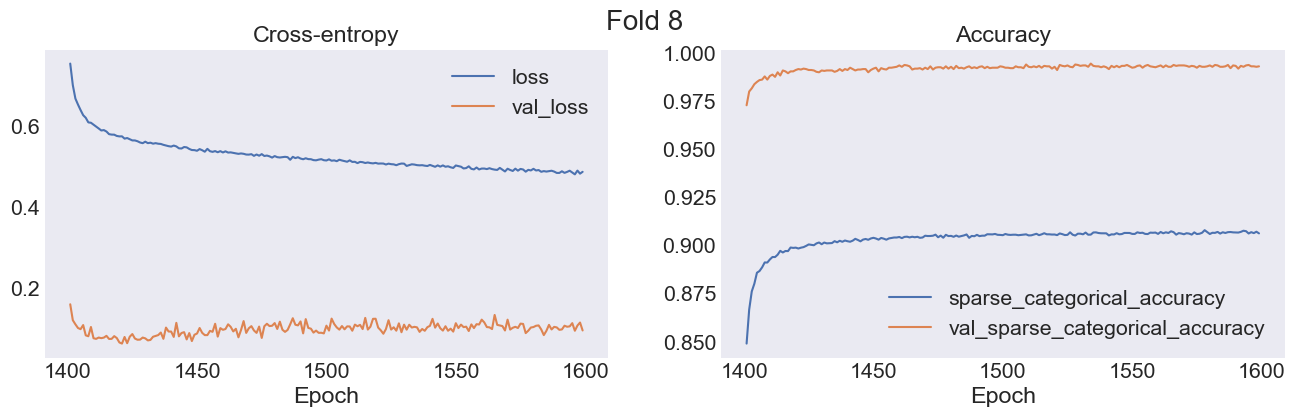

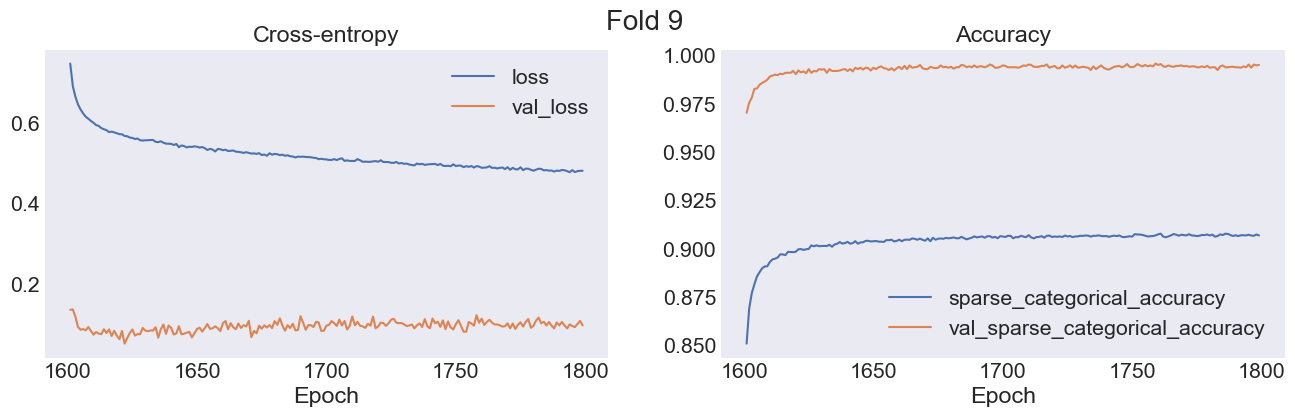

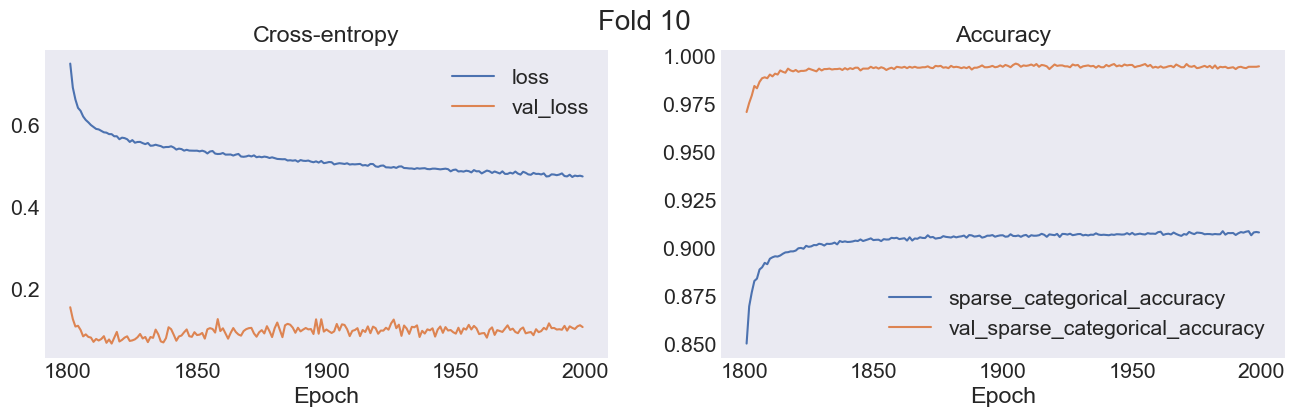

In [19]:
for i in range(FOLDS):
    
    plt.style.use("seaborn-v0_8-dark")
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,4))
    plt.suptitle('Fold '+str(i+1), fontsize=20)
    
    plt.subplot(1,2,1)
    ax=history_df.reset_index().loc[EPOCHS*i+1:EPOCHS*(i+1)-1, ['loss', 'val_loss']].plot(title="Cross-entropy", ax=axes[0])
    plt.xlabel('Epoch')
    
    plt.subplot(1,2,2)
    ax=history_df.reset_index().loc[EPOCHS*i+1:EPOCHS*(i+1)-1, ['sparse_categorical_accuracy', 'val_sparse_categorical_accuracy']].plot(title="Accuracy", ax=axes[1])
    plt.xlabel('Epoch')

**Soft voting**

In [20]:
# Soft voting to ensemble predictions
test_preds = np.argmax(test_preds, axis=1)

**Plot predictions**

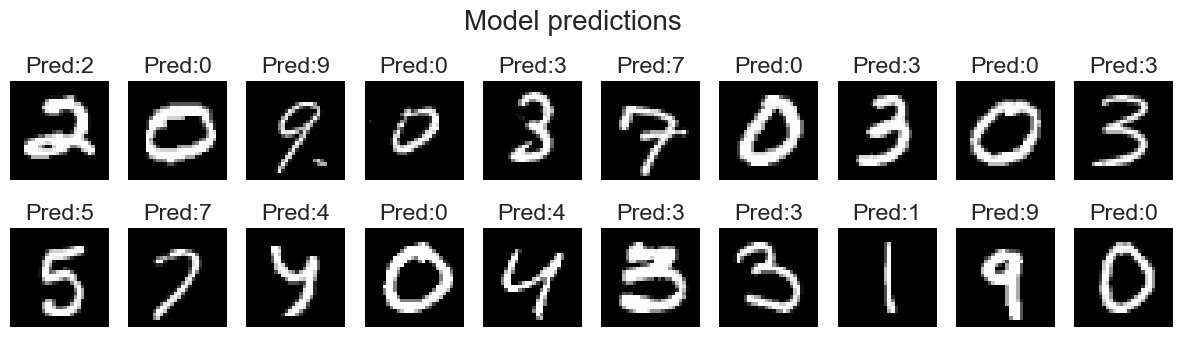

In [21]:
# Plot some model predictions
plt.figure(figsize=(15,3.5))
plt.suptitle('Model predictions', fontsize=20, y=1.05)

# Subplot
for i in range(20):
    img = test_data[i];
    ax=plt.subplot(2, 10, i+1)
    ax.grid(False)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.title.set_text(f'Pred:{test_preds[i]}')
    plt.imshow(img, cmap='gray')
    
plt.show()

# Submission

In [22]:
# Save predictions to file
output = pd.DataFrame({'ImageId': test_index+1,
                       'Label': test_preds})

# Check format
output.head()

print('jo')

jo


In [23]:
output.to_csv('submission.csv', index=False)